<img src="./logo_UNSAM.jpg" align= "right" width= "150" /> -->
## APS
## Trabajo práctico semanal 8: *Filtrado NO lineal*
### Violeta Manterola

En la TS7 se experimentaron técnicas de filtrado lineal para la mitigación de interferencias en la señal electrocardiográfica (ECG). Tal vez la interferencia que más exigió el diseño de los filtros digitales ha sido el movimiento de línea de base del ECG. La misma se trata de oscilaciones de muy baja frecuencia (< 0.5 Hz) y en ocaciones de alta energía. En esta tarea semanal se analizarán técnicas no lineales de estimación/substracción de la señal de movimiento de base $b_{n}$

$$
\hat{x} = s - \hat{b}
$$
Siendo $ s $ la señal de ECG registrada **con interferencias**, y $ \hat{x} $ la señal filtrada, una estimación del ECG **sin interferencias**:

Se pide que implemente ambas estimaciones de $\hat{b}$ detalladas a continuación:

#### 1) Filtro de mediana

Se estima $\hat{b} $ a partir de la siguiente expresión:

$$
\hat{b} = \text{med}_{600} \left( \text{med}_{200}(s) \right)
$$

siendo $\text{med}_t(s)$ el operador de mediana de **t milisegundos** que se aplica sobre la señal $s$, es decir:

$$
m[n] = \text{med}(s[n], s[n-1], \dots, s[n - 200 \cdot f_s])
$$

$$
\hat{b}[n] = \text{med}(m[n], m[n-1], \dots, m[n - 600 \cdot f_s])
$$

**Ayuda:** Puede utilizar la implementación del **filtro de mediana** provista en `scipy.signal`.

---
#### 2) Interpolación mediante splines cúbicos 
A partir de las detecciones provistas en ecg.mat (campo qrs_detections), puede estimar el nivel isoeléctrico, es decir el momento donde la actividad eléctrica cardíaca es **aproximadamente nula**. El intervalo entre la onda P y Q, es el momento más adecuado para estimar las características de la la interferencia que originan el movimiento de la línea de base. En ese momento el impulso cardíaco es demorado al atravesar el nódulo aurículo-ventricular.

Para la localización del segmento PQ puede valerse de la localización de cada latido (líneas rojas verticales ($n_{i}$) y a partir de la misma, anticipar un tiempo adecuado ($n_{0}$) de manera tal de **no incluir la onda P ni Q**. Esto resultará en un conjunto valores:
$$
S = \{(m_i, s(m_i)) \mid i = 1, 2, \dots, Q \}
$$
donde:

- $ m_i = n_i - n_0 $
- $Q $ es la cantidad de latidos detectados en el registro ($Q$ = 1903).
- $s(m_i)$ es el valor de la señal ECG en ese instante.

Recuerde que la señal de línea de base debe estar muestreada a la misma frecuencia que el ECG, por lo que debería remuestrear dicha señal (puede usar la función de interpolación spline para ello).
$$
\hat{b}(n) = \text{spline}_3(S, n) \quad \text{para} \quad n = 1, 2, \dots, N
$$
donde la función $ spline_3 $ será la responsable de realizar la interpolación para las $N$ muestras de la señal $s$.

---
#### 3) Filtro adaptado (matched filter)
Aplique el concepto de **filtro adaptado** para diseñar un detector de latidos. Utilice el patrón provisto en el campo **qrs_pattern1**.

a) Explique conceptualmente cómo podría realizar un detector de latidos con la señal resultante del filtro adaptado. Discuta la utilidad y limitaciones de este método.

b) Realice la detección de los latidos, comparando las detecciones obtenidas con las que se incluyen en la variable qrs_detections. Proponga alguna métrica (sensibilidad, valor predictivo positivo) para cuantificar la performance del detector.

-------------------------------------------------------------------------------------------------------------------------------------------


## **Filtrado No lineal**:

En esta tarea se utiliza el filtrado no lienal para poder eliminar la interferecia de la línea de base del ECG, a diferencia de lo que veníamos haciendo en la ts7. En este caso, usamos filtrado NO lineal, esto implica que ahora la salida no será proporcional a la entrada, es decir, que el principio de superposición no se cumple y que la salida no puede predecirse simplemente escalando y sumando las entradas. 

Se utilizaron dos métodos de filtrado no lineal: 

 - Filtro de mediana: Dado un punto en la señal, se toma una ventana de valores vecinos (por ejemplo, 5 muestras), y se reemplaza el valor central por la mediana de esos valores. Este filtro suprime picos aislados sin afectar demasiado el contenido general de la señal.
 - Filtro por splines cúbicos: es realizar una interpolación de la señal usando funciones spline cúbicas (polinomios de grado 3)

El objetivo es filtrar con ambos métodos la interferencia del movimiento de línea de base del ECG, oscilaciones de muy baja frecuencia (<5Hz). 

In [28]:
import sympy as sp
import numpy as np
import scipy.signal as sig
from scipy.signal.windows import hamming, kaiser, blackmanharris
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.signal import find_peaks

#%%señal ECG
fs_ecg = 1000
fs = fs_ecg
mat_struct = sio.loadmat('./ECG_TP4.mat')
ecg_one_lead =(mat_struct['ecg_lead']).flatten()

# segmento de interes
ecg_segment = ecg_one_lead[700000:745000] #region de interes en caso de no muestrear todo el ecg
N = len(ecg_one_lead) #cantidad de muestras
t_segment = np.linspace(0,len(ecg_segment)/fs_ecg, len(ecg_segment) )

# Normalización tipo z-score: (x - media) / std
def normalize(signal):
    return (signal - np.mean(signal)) / np.std(signal)

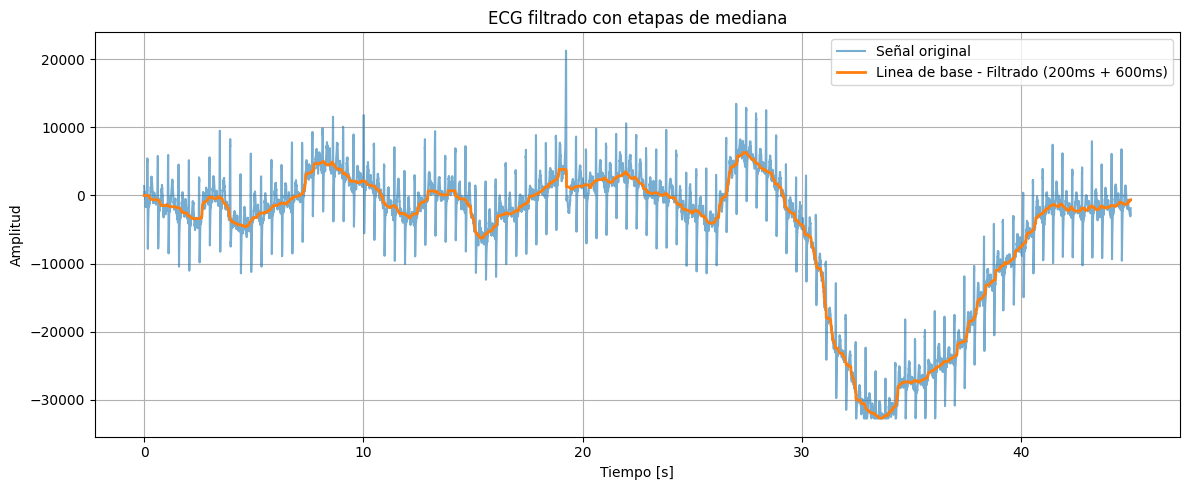

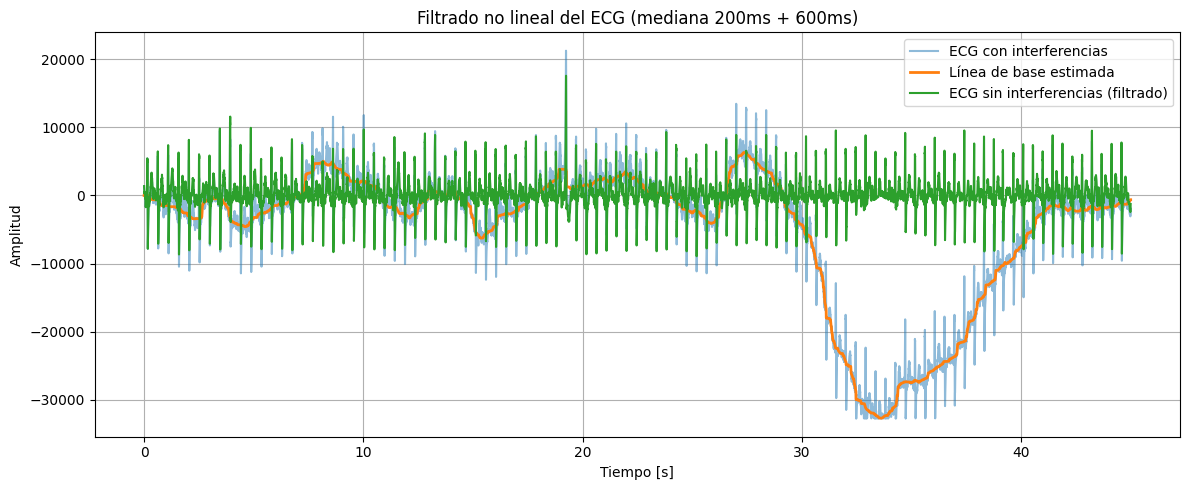

In [29]:
#%%  FILTRO DE MEDIANA
# Ventanas
win1_samples = 200 #primero una ventana más estrecha
win2_samples = 600 #luego aplico una ventana más amplia al filtro anterior

# Aseguro q sea impar => si es par le sumo 1 
if win1_samples % 2 == 0:
    win1_samples += 1
if win2_samples % 2==0:
    win2_samples +=1
    
#print(win1_samples,win2_samples) #asi verifico que son impar
#filtros de mediana --> linea de base 

#primer filtro de mediana (200ms)
ecg_med1 = sig.medfilt(ecg_segment,kernel_size=win1_samples)

#segundo filtro de mediana (600ms) -->al reusltado del filtro anterior le aplico otro con ventana de 600ms
ecg_med2 = sig.medfilt(ecg_med1,kernel_size=win2_samples) # lo conceto en casacada con el q acabo de hacer

#entonces ecg registrado sin interferencias me quedaría: 
ecg_sin_interferencias = ecg_segment - ecg_med2 #al ecg le resto la linea de base que filtre!

#%% Visualizacion -----------------------------------------------------------------------------------------------------------
# --- Primero grafico lo que sería la línea de base del ECG-----------
plt.figure(figsize=(12,5))
plt.plot(t_segment, ecg_segment, label='Señal original',alpha=0.6)
plt.plot(t_segment, ecg_med2, label='Linea de base - Filtrado (200ms + 600ms)', linewidth=2)
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.title('ECG filtrado con etapas de mediana')
plt.legend
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

#le sumo al grafico entonces como quedaria el ecg filtrado por filtro de mediana 
plt.figure(figsize=(12,5))
plt.plot(t_segment, ecg_segment, label='ECG con interferencias', alpha=0.5)
plt.plot(t_segment, ecg_med2, label='Línea de base estimada', linewidth=2)
plt.plot(t_segment, ecg_sin_interferencias, label='ECG sin interferencias (filtrado)', linewidth=1.5)
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.title('Filtrado no lineal del ECG (mediana 200ms + 600ms)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

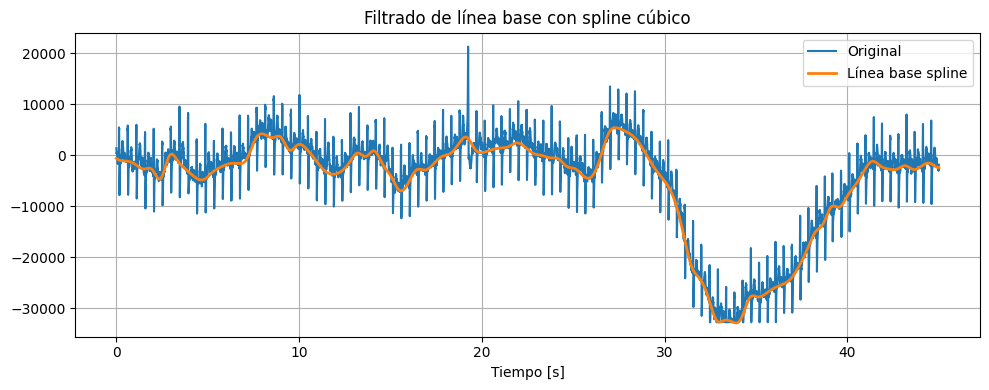

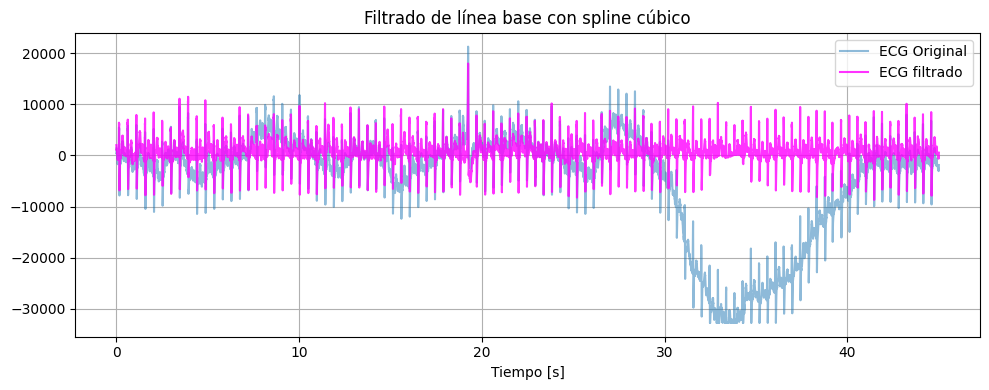

In [30]:
#%%  FILTRO MEDIANTE SPLINES CÚBICOS -----------------------------------------------
from scipy.interpolate import CubicSpline

#cubicspline: interpolará exactamente los puntos que le das como entrada, generando una función suave, compuesta de segmentos cúbicos, con continuidad de primera y segunda derivada.

#tomar cierto intervalo  antes del complejo QRS --> xq es dodne la señal suele estar mas estable
# entonces así asi evito la distorsion del complejo QRS 
# spline = CubicSpline(t_segment, y)

#cargo el vector qrs_detections --------------------------------------------------------------------------------------------
qrs = (mat_struct['qrs_detections']).flatten() #utilizo vector qrs_detections para identificar los segmentos isoélectricos entre la onda P y el complejo QRS
#xq mat_struct es un diccionario :)

# grafico el ECG con el qrs_detections para así estimar que punto previo al complejo tomar !

# luego del grafico --> estimo alrededor de 90ms pre complejo QRS en una ventana de 20 ms para evitar agarra tanta varianza

# confirguro entonces: 
punto_previo = 90 #a ojo aprox para estimar el nivel isoeléctrico (evitando la onda p y complejo qrs, x eso lo ubico antes asi lo puedo restar)
ventana = 20 # Tomar una ventana corta (por ejemplo, 20 ms) para calcular un valor de referencia
segmentos = []
t_base = []

for idx in qrs:
    i_ini = idx - punto_previo 
    i_fin = i_ini + ventana
    if i_ini >= 0 and i_fin < len(ecg_one_lead):
        segmento = ecg_one_lead[i_ini:i_fin]
        segmentos.append(segmento)
        t_base.append(i_ini + ventana // 2)  # punto central del segmento para usar como soporte temporal del spline

segmentos_array = np.array(segmentos)
puntos_base = np.mean(segmentos_array, axis=1)  # media por latido
t_base = np.array(t_base)

# spline sobre toda la señal -->Interpolar esos puntos usando un spline cúbico para obtener la estimación de la línea de base en toda la señal.
cs_total = CubicSpline(t_base, puntos_base)
spline_total = cs_total(np.arange(len(ecg_one_lead)))

# entonces señal de ecg filtrada sin intereferencias :
ecg_filtrado = ecg_one_lead - spline_total


# ----------------------------------------- VISUALIZACIÓN ----------------------------------------------------
# graficar en el segmento de interés con la linea de base
plt.figure(figsize=(10,4))
plt.plot(t_segment, ecg_segment, label='Original')
plt.plot(t_segment, spline_total[700000:745000], label='Línea base spline', linewidth=2)
plt.xlabel('Tiempo [s]')
plt.title('Filtrado de línea base con spline cúbico')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#grafico ecg_filtrado 
plt.figure(figsize=(10,4))
plt.plot(t_segment, ecg_segment, label='ECG Original', alpha=0.5)
plt.plot(t_segment, ecg_filtrado[700000:745000], color ='magenta',label='ECG filtrado', alpha=0.8)
plt.xlabel('Tiempo [s]')
plt.title('Filtrado de línea base con spline cúbico')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


#### **ANÁLISIS**

Como puede apreciarse en los gráficos, tanto del filtrado de mediana como por splines cúbicos, ambas técnicas resultan altamente efectivas para mitigar el movimiento de línea de base del ECG. Por un lado, el filtro de mediana es simple de configurar pero depende del tamaño de ventanas elegido. Mientras que el filtrado por splines cúbicos es un método más suave y adaptativo que ajusta una curva continua (splines) a puntos representativos de la línea de base; pero depende de indentificar lo mas eficientemente posible el punto previo al complejo QRS (punto de anclaje).

--------------------------------------------------------------------------------------------------------------------------------------------

###  **Filtro adaptado (matched filter)** 
#### > *detector de latidos*

El filtro adaptado (matched filter) será utilizado para implementar un *detector de latidos*. Su salida es la correlación entre un patrón conocido, en este caso el patron del complejo QRS (qrs_pattern1), y la señal de ECG; por ende el objetivo es detectar la ocurrencia de ese patrón a lo largo de la señal ECG. Al utilizar la correlación invertida entonces resaltará las regiones donde la señal se asemeja al patrón, generando máximos locales en la salida del filtro cuando ocurre una coincidencia. 

Teniendo en cuenta esto, interpretaremos esos máximos (picos de amplitud en la salida del filtro) como posibles latidos, ya que indican que la forma de la señal en ese instante se parece al complejo QRS (el cuál ocurre una vez por latido); así es como configuramos un detector de latidos. 

Por último, los instantes detectados pueden compararse con las posiciones reales (qrs_detections) para evaluar la performance del detector mediante métricas como sensibilidad y valor predictivo positivo.

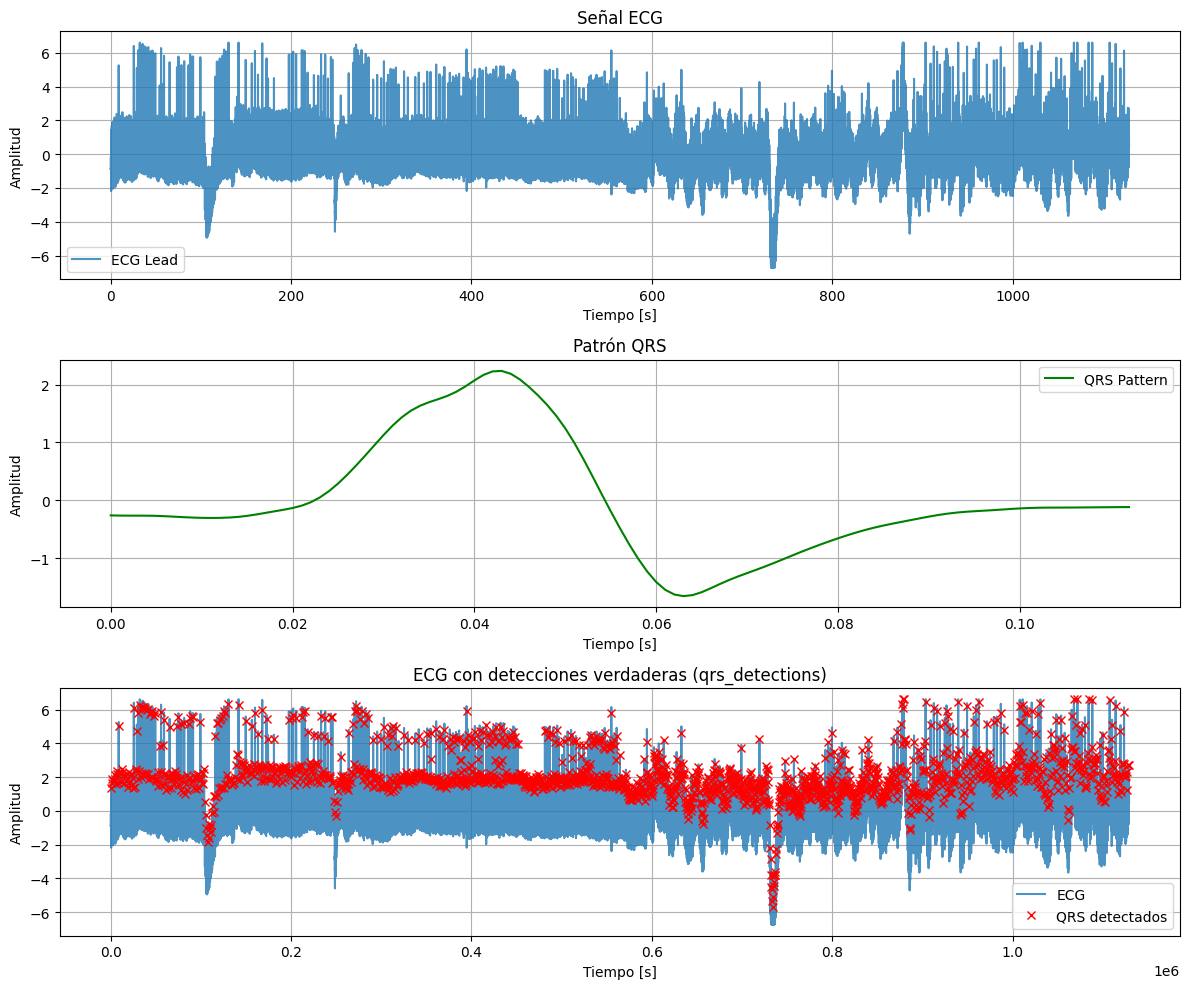

In [46]:
# --------------------------------------------------------------------------------------------------------------------------------
#grafico de la señal de ECG y el patrón QRS que se va a utilzizar para la correlación
ecg = ecg_one_lead
t_qrs = np.arange(len(qrs_pattern)) / fs_ecg
qrs_detections = mat_struct['qrs_detections'].flatten()
t_ecg = np.arange(len(ecg)) / fs_ecg
# Crear gráfico con 3 subplots
plt.figure(figsize=(12, 10))

# 1) Señal ECG completa
plt.subplot(3, 1, 1)
plt.plot(t_ecg, ecg, label='ECG Lead', alpha=0.8)
plt.title('Señal ECG')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.grid(True)
plt.legend()

# 2) Patrón QRS
plt.subplot(3, 1, 2)
plt.plot(t_qrs, qrs_pattern, label='QRS Pattern', color='green')
plt.title('Patrón QRS')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.grid(True)
plt.legend()

# 3) ECG con detecciones verdaderas
plt.subplot(3, 1, 3)
plt.plot(ecg, label='ECG Lead', alpha=0.8)
plt.plot(qrs, ecg_one_lead[qrs], 'rx', label='QRS detectados')
plt.title('ECG con detecciones verdaderas (qrs_detections)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.grid(True)
plt.legend(['ECG', 'QRS detectados'])

plt.tight_layout()
plt.show()


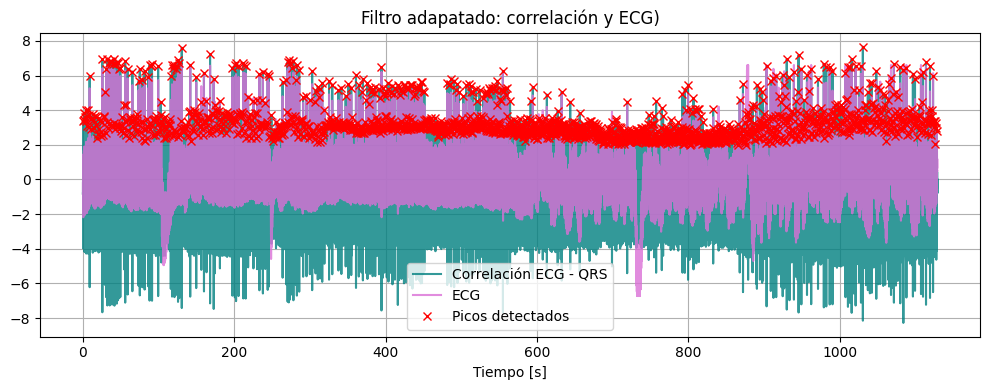

In [80]:

# ---------------------------------------FILTRO ADAPTADO-----------------------------------------------------------------------#
# la idea aca es: 
    #Correlacionar la señal ECG con un patrón típico de QRS (qrs_pattern1).
    # El filtro adaptado responde fuertemente cuando la forma del patrón aparece en la señal.
    # Esto genera picos en la salida que corresponden al momento del latido.

#cargo el patron qrs que uso en la correlación ------------------------------------------------------------------------------------------------------
qrs_pattern = mat_struct['qrs_pattern1'].flatten()

#cargo qrs_detections que serám mis verdaderos latidos ----------------------------------------------------------------------------------------------
qrs_true = mat_struct['qrs_detections'].flatten()

# Normalización tipo z-score: (x - media) / std
ecg_one_lead = normalize(ecg_one_lead)
qrs_pattern = normalize(qrs_pattern)

#  ARMO EL FILTRO ADAPTADO (MATCHED_FILTER)  = correlación con el patrón (invertido y desplazado) ------------------------------------------------------

matched_filter = np.correlate(ecg_one_lead, qrs_pattern[::-1], mode='same') #para que sea una correlación cruzada
matched_filter = normalize(matched_filter)
# --------------------------- DETECCIÓN PICOS ---------------------------------------------------------------------------------------
# SIGUIENTE PASO DETECTAR LOS PICOS DE LA CORRELACIÓN (SON LAS COINCIDENCIAS QUE SE VEN MAXIMIZADAS!) 
peaks, properties = find_peaks(matched_filter,height=2, distance=250)  # ~250 ms si fs = 1000 Hz

# Crear vector de tiempo para la correlación
fs = 1000  # Hz
t_corr = np.arange(len(matched_filter)) / fs

# --------------------------------VISUALIZACIÓN -------------------------------------------------------------------
# Graficar correlación con los picos
plt.figure(figsize=(10, 4))
plt.plot(t_corr, matched_filter, color='teal', alpha = 0.8, label='Correlación ECG - QRS')
plt.plot(t_corr, ecg_one_lead, color = 'orchid' ,alpha = 0.8,label='ECG')
plt.plot(t_corr[peaks], matched_filter[peaks], 'rx', label='Picos detectados')
plt.title('Filtro adapatado: correlación y ECG)')
plt.xlabel('Tiempo [s]')
plt.ylabel('')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

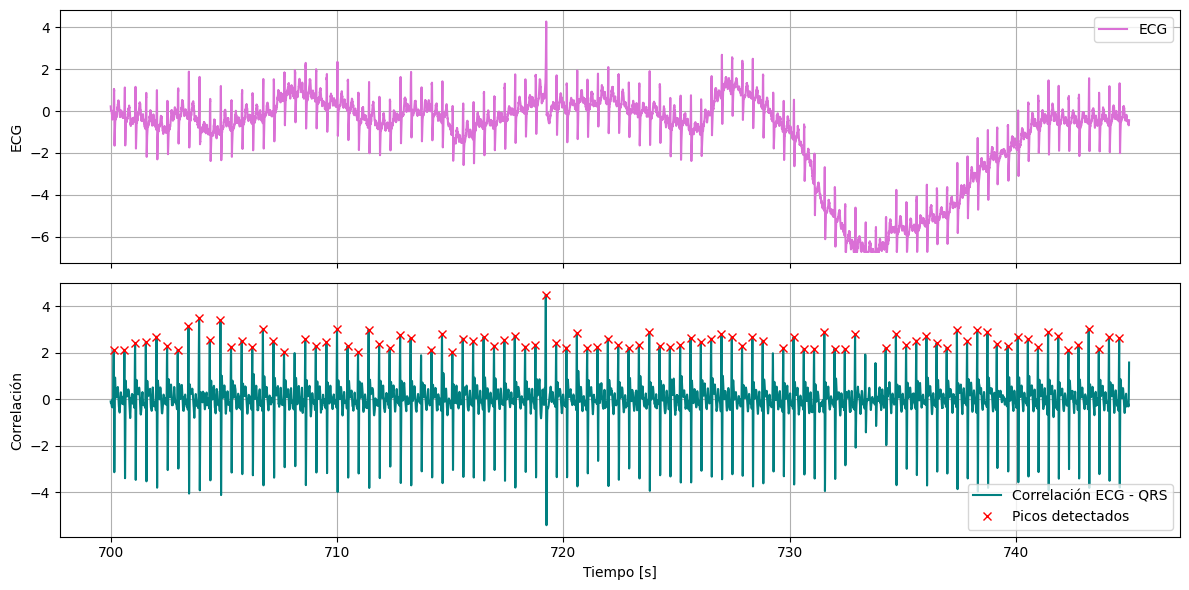

In [47]:

# ---- PLOTEO X SEPARADO ECG Y LA CORRELACIÓN CON LOS PEAKS (EN SEGMENTO DE INTERÉS PARA MEJOR VISUALIZACIÓN) ----------#
ecg_one_lead = normalize(ecg_one_lead)
qrs_pattern = normalize(qrs_pattern)

matched_filter = np.correlate(ecg_one_lead, qrs_pattern[::-1], mode='same') #para que sea una correlación cruzad
matched_filter = normalize(matched_filter)

peaks, properties = find_peaks(matched_filter,height=2, distance=250)  # ~250 ms si fs = 1000 Hz

def plot_ecg_correlacion(ecg, corr, peaks, t, start, stop):
    """
    Plotea un segmento de ECG y su correlación con detección de picos.
    Parámetros:
    - ecg: señal del ECG completa
    - corr: salida del filtro adaptado (correlación)
    - peaks: índices de picos detectados
    - t: vector de tiempo
    - start, stop: índices de inicio y fin del segmento
    """
    seg = slice(start, stop)
    
    ecg_seg = ecg[seg]
    corr_seg = corr[seg]
    t_seg = t[seg]
    
    peaks_seg = peaks[(peaks >= start) & (peaks < stop)]

    fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

    axs[0].plot(t_seg, ecg_seg, label='ECG', color='orchid')
    axs[0].set_ylabel('ECG')
    axs[0].legend()
    axs[0].grid(True)

    axs[1].plot(t_seg, corr_seg, label='Correlación ECG - QRS', color='teal')
    axs[1].plot(t[peaks_seg], corr[peaks_seg], 'rx', label='Picos detectados')
    axs[1].set_xlabel('Tiempo [s]')
    axs[1].set_ylabel('Correlación') 
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()
plot_ecg_correlacion(ecg_one_lead, matched_filter, peaks, t_corr, 700000, 745000)

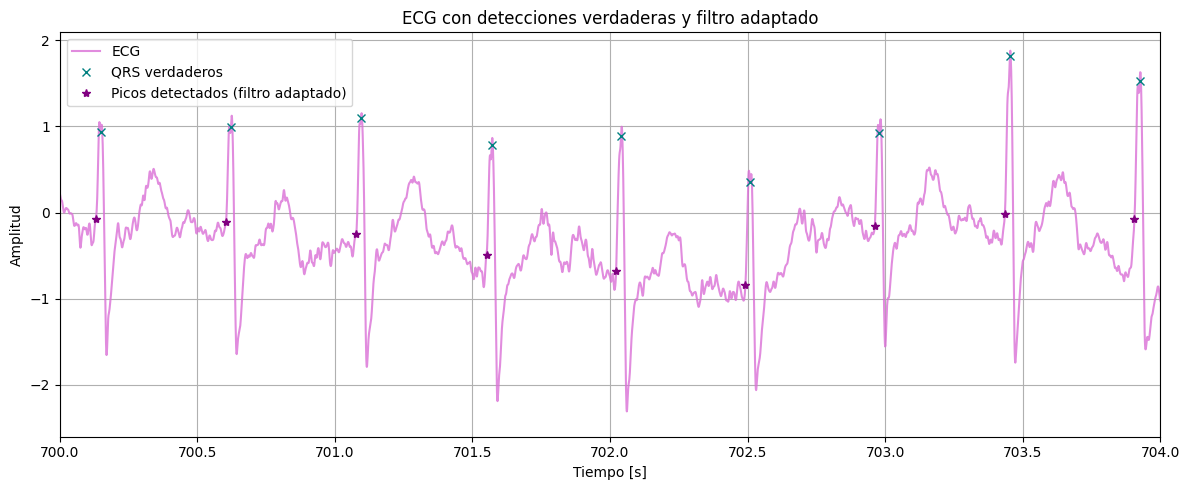

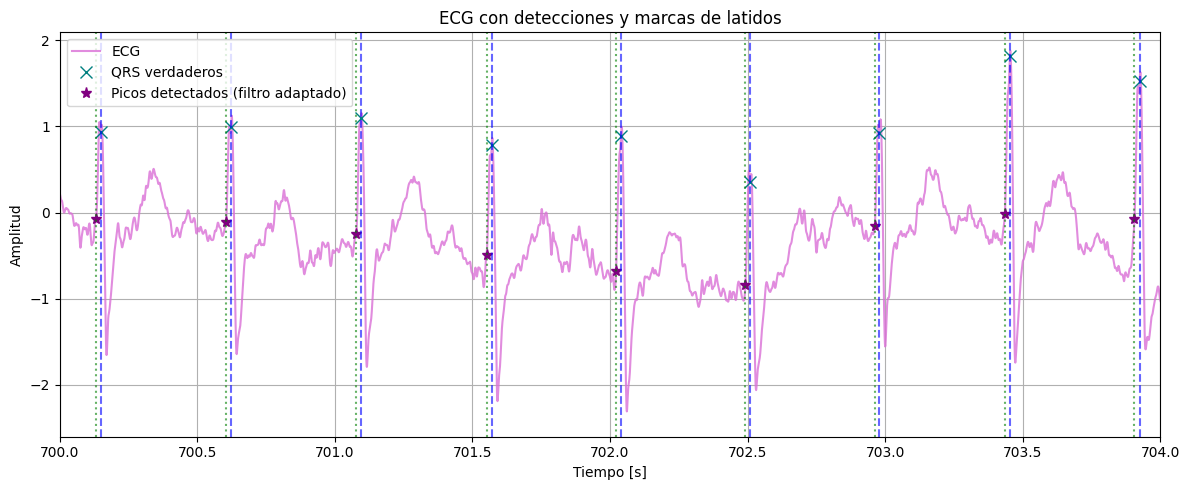

In [55]:
# ---------COMPARACIÓN PEAKS (latidos encontrados con matched filter) Y LOS QRS_DETECTIONS ------------------------------------------

# Segmento elegido [ms]
start = 700000
stop = 705000
ecg_segment = ecg_one_lead[start:stop]
t_corr = np.arange(len(ecg_segment)) / fs

# Crear vector de tiempo para ese tramo
t_ecg = np.arange(len(ecg_one_lead)) / fs
t_segmento = t_ecg[start:stop]

# Filtrar detecciones verdaderas (qrs_true) dentro del rango
qrs_true_segmento = qrs_true[(qrs_true >= start) & (qrs_true < stop)]

# Filtrar picos detectados por filtro adaptado (peaks)
peaks_segment = peaks[(peaks >= start) & (peaks < stop)]


# Graficar
plt.figure(figsize=(12, 5))
plt.plot(t_segmento, ecg_segment, label='ECG', color='orchid', alpha=0.8)

# Detecciones verdaderas (por ejemplo en rojo)
plt.plot(t_ecg[qrs_true_segmento], ecg_one_lead[qrs_true_segmento], 'x', color = 'teal', label='QRS verdaderos')

# Picos detectados con filtro adaptado (por ejemplo en azul)
plt.plot(t_ecg[peaks_segment], ecg_one_lead[peaks_segment], '*', color='purple', label='Picos detectados (filtro adaptado)')

plt.title('ECG con detecciones verdaderas y filtro adaptado')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.xlim(700,704)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))

# Señal ECG
plt.plot(t_segmento, ecg_segment, label='ECG', color='orchid', alpha=0.8)

# Detecciones verdaderas (QRS)
plt.plot(t_ecg[qrs_true_segmento], ecg_one_lead[qrs_true_segmento], 'x', markersize=8, color = 'teal', label='QRS verdaderos')

# Detecciones por filtro adaptado (picos)
plt.plot(t_ecg[peaks_segment], ecg_one_lead[peaks_segment], '*',  markersize=8, color='purple', label='Picos detectados (filtro adaptado)')

# Líneas verticales para marcar los latidos verdaderos
for t_qrs in t_ecg[qrs_true_segmento]:
    plt.axvline(x=t_qrs, color='blue', linestyle='--', alpha=0.6)

# Líneas verticales para marcar los picos detectados
for t_peak in t_ecg[peaks_segment]:
    plt.axvline(x=t_peak, color='darkgreen', linestyle=':', alpha=0.6)

plt.title('ECG con detecciones y marcas de latidos')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.xlim(700,704)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



Acá podemos observar una comparación gráfica de lo que detecta el filtro adaptado con la correlación que armamos entre el qrs_pattern_1 y el ecg vs lo que detecta el qrs_detections, que se denomina latido verdadero. Se puede apreciar que la señal resultante del filtro adaptado presenta picos donde la señal ECG coincide morfológicamente con el patrón típico de QRS. Como se observa en la segunda figura, si trazamos una linea en los picos detectados (estrellas violetas) y una en los picos del qrs verdadero (marcador azul), interpretandolas como marcas de los latidos vemos como ambos son muy similares. Cabe destacar que existe un defasaje o demora entre ambos, esto se adjudica a que la correlación no detecta necesariamente el centro del complejo QRS; pero lo importante es que marque uno por complejo QRS (equivalente a uno por latido).

------------------------------------------------------------------------------------------------------------------------------------------
#### **Evaluación performance detector:**

Para poder comparar las detecciones obtenidas de latidos (peaks) con las verdaderas que se incluyen en la varibale qrs_dettections, se debe definir alguna métrica, una forma cuantitativa de evaluar la performance del detector; como la sensibilidad o el valor predictivo positivo (son los más comunes). 

La sensibilidad (TPR) es la proporción de verdaderos latidos detectados (true positive rate); es decir mide qué tan bien el detector encuentra los latidos verdaderos.
$$
Sensibilidad = \frac{TP}{TP+FN}
$$
Valor predictivo positivo (PPV) indica la proporción de detecciones que fueron correctas; es basicamente para notar de todos los picos que detectó cuales son realmente latidos correctos.  
$$
PPV = \frac{TP}{TP+FP}
$$
 
Para poder definir TP (verdadero positivo), FP (falso positivo) y FN (falso negativo), hay que tener en cuenta que puede haber un desfasaje pequeño entre la detección real y la estimada, es por esto que se definde una tolarancia, es decir un rango en donde se considera la detección (peak) correcta si esta en ese intervalo. Teniendo en cuenta la naturaleza d ela señal fisiológica y que el complejo QRs puede llegar a durar hasta 120ms, y sumandole el hecho de que la correlación puede detectar el pico antes o después del centro real del QRS: se optó por configurar una toleancia de 100ms. 

En base a aestos parámetros uno espera que ambos sean altos, es decir, que mi detector tenga una alta sensibilidad (detecte la mayor cantidad de picos posibles) y que tenga una buena presición (que esos picos que detecta sean válidos)


In [70]:
def evaluar_performance(peaks_detectados, qrs_verdaderos, fs, tolerancia_ms=100):
    tolerancia_muestras = int((tolerancia_ms / 1000) * fs)
    
    #inicializo variables en 0

    TP = 0
    FP = 0
    FN = 0

    # Convertir a sets para ir marcando qué detecciones se usan
    verdaderos = set(qrs_verdaderos)
    verdaderos_usados = set() #para no contar el mismo latido más de una vez 
    verdaderos_detectados = 0

    # Comparar cada pico detectado con los verdaderos
    for p in peaks_detectados:
        for v in verdaderos:
            if abs(p - v) <= tolerancia_muestras and v not in verdaderos_usados: #mide que la difernecia entre el latido que se detectó y el verdadero sea menor a la tolerancia indeicada
                verdaderos_detectados += 1
                verdaderos_usados.add(v)
                break

    TP = verdaderos_detectados
    FN = len(qrs_verdaderos) - TP #latidos verdaderos que no fueron detectados.
    FP = len(peaks_detectados) - TP # detecciones de más que no eran latidos verdaderos.

    sensibilidad = TP / (TP + FN) if (TP + FN) > 0 else 0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    return {
        'Sensibilidad': sensibilidad,
        'Precision (PPV)': precision,
        'TP': TP,
        'FP': FP,
        'FN': FN
    }


In [79]:

qrs_true = mat_struct['qrs_detections'].flatten()
sens, prec, TP, FP, FN = evaluar_performance(peaks, qrs_true, fs=1000)
import pandas as pd

resultados = evaluar_performance(peaks, qrs_true, fs=1000)
df = pd.DataFrame(resultados.items(), columns=['Métrica', 'Valor'])
display(df.round(3))

print(f"Cantidad de qrs verdaderos: {len(qrs_true)}")
print(f"Cantidad de detecciones: {len(peaks)}")

,Métrica,Valor
0,Sensibilidad,0.992
1,Precision (PPV),0.999
2,TP,1888.000
3,FP,1.000
4,FN,15.000


Cantidad de qrs verdaderos: 1903
Cantidad de detecciones: 1889


Analizando los resultados obtenidos en la evaluación de la performance del dectector de latidos (comparado con latidos verdaderos) puede decirse que:

 - el detector posee **alta sensibilidad**, identificando correctamente el 99.2% de los latidos reales (solo paso por alto 15 latidos)
 - alta precisión, ya que de todos los latidos que detectó, el 99.9% eran correctos (solo una detección errónea) 

Por lo tanto, se concluye que el presente detector diseñado por correlación resulta válido para detectar latidos en un ECG; ya que es bastante efectivo con una mínima tasa de error, en lo que se refiere a detectar los latidos y más que nada en no equivocarse en ellos. Todo esto indica que el patrón que el patrón para la correlación está muy bien definido y la tolerancia definida también fue acertada. 